In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # for train test split
from sklearn.feature_extraction import DictVectorizer # for one-hot encoding
from sklearn.tree import DecisionTreeRegressor # decision tree regressor (for q1)
from sklearn.tree import export_text # text output of tree for q1
from sklearn.ensemble import RandomForestRegressor # random forest regressor (for q2)
from sklearn.metrics import mean_squared_error # for q2
from tqdm.auto import tqdm # for q3
import matplotlib.pyplot as plt # for q3
import xgboost as xgb # for q6
#import matplotlib as mpl
#import seaborn as sb

In [35]:
df = pd.read_csv("housing.csv")

In [91]:
# 0 Preliminary tasks
# 0.1 Use only the following columns:
#     'latitude', 'longitude', 'housing_median_age', 'total_rooms',
#     'total_bedrooms', 'population', 'households', 'median_income',
#     'median_house_value', 'ocean_proximity'
df = df[['latitude', 'longitude', 'housing_median_age', 'total_rooms',
         'total_bedrooms', 'population', 'households', 'median_income',
         'median_house_value','ocean_proximity']].copy()
# 0.2 Fill NAs with 0.
# df.isna().sum()[df.isna().sum()>0] # --> 207 NAs in column 'total_bedrooms'
df['total_bedrooms'] = df['total_bedrooms'].fillna(0, inplace=False)

# 0.3 Apply the log tranform to median_house_value.
df['log_median_house_value'] = np.log1p(df['median_house_value'])

# 0.4 Do train/validation/test split with 60%/20%/20% distribution.
#     Use the train_test_split function and set the random_state parameter to 1.
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    df.drop(['median_house_value', 'log_median_house_value'], axis = 1),
    df[['log_median_house_value']],
    train_size = 0.8,
    test_size = 0.2,
    random_state = 1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid,
    y_train_valid,
    train_size = 0.75,
    test_size = 0.25,
    random_state = 1)

#print(X_train.shape)
#print(X_valid.shape)
#print(X_test.shape)

# extract column names to use as labels later
X_names = X_train.columns.values.tolist()

# 0.5 Use DictVectorizer to turn the dataframe into matrices.
train_dict = X_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False) # initialize DictVectorizer on df that contains all relevant information
X_train = dv.fit_transform(train_dict)

valid_dict = X_valid.to_dict(orient='records')
X_valid = dv.transform(valid_dict)

test_dict = X_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [92]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(12384, 13)
(4128, 13)
(4128, 13)


In [65]:
print(type(dv.get_feature_names()))
print(type(dv.get_feature_names_out()))
# a very important difference if you want to use the latter in export_text below...

<class 'list'>
<class 'numpy.ndarray'>


In [67]:
# Question 1

# Let's train a decision tree regressor to predict the median_house_value variable.
regressor = DecisionTreeRegressor(max_depth = 1)
# Train a model with max_depth=1.
regressor.fit(X_train, 
              y_train)

# Which feature is used for splitting the data?
#print(export_text(regressor))
export_text(regressor, feature_names=dv.get_feature_names_out().tolist())

#print("X_train feature at index position 6 is \n", dv_train.get_feature_names_out()[6])
# dv_train.get_feature_names_out()

# --> ocean_proximity=INLAND <--
# total_rooms
# latitude
# population

'|--- ocean_proximity=INLAND <= 0.50\n|   |--- value: [12.31]\n|--- ocean_proximity=INLAND >  0.50\n|   |--- value: [11.61]\n'

In [71]:
# Question 2

# Train a random forest model with these parameters:
rf = RandomForestRegressor(n_estimators = 10, 
                           random_state = 1, 
                           n_jobs = -1)
rf.fit(X_train, y_train)

# n_estimators=10
# random_state=1
# n_jobs=-1 (optional - to make training faster)
# What's the RMSE of this model on validation?

y_pred = rf.predict(X_valid)
np.sqrt(mean_squared_error(y_valid, y_pred))

# 0.05
# --> 0.25 <--
# 0.55
# 0.85

/tmp/ipykernel_2125/730463388.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


0.24566012875324933

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_2125/2283814409.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/2283814409.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/2283814409.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/2283814409.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/2283814409.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

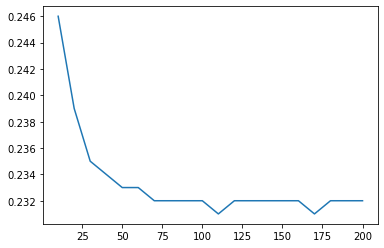

In [82]:
# Question 3

# Now let's experiment with the n_estimators parameter

scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators = n, 
                               random_state = 1, 
                               n_jobs = -1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

# Try different values of this parameter from 10 to 200 with step 10.
# Set random_state to 1.
# Evaluate the model on the validation dataset.


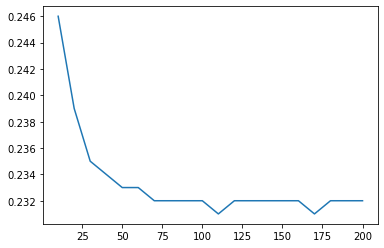

In [79]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

# After which value of n_estimators does RMSE stop improving?

# 10
# 55
# --> 75 <--
# 150

In [80]:
# Question 4

# Let's select the best max_depth:

# Try different values of max_depth: [10, 15, 20, 25]
# For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
# Fix the random seed: random_state=1

scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_valid)
        score = np.sqrt(mean_squared_error(y_valid, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/tmp/ipykernel_2125/3864656522.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

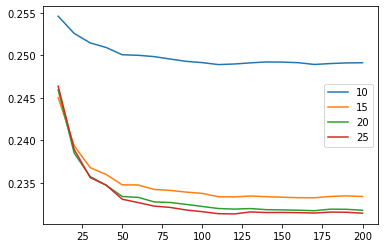

In [81]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
# What's the best max_depth:

# 10
# 15
# 20
# --> 25 <--

In [83]:
# Question 5

# We can extract feature importance information from tree-based models.

# At each step of the decision tree learning algorithm, it finds the best split. 
# When doin it, we can calculate "gain" - the reduction in impurity before and after the split. 
# This gain is quite useful in understanding what are the imporatant features for tree-based models.

# In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

# For this homework question, we'll find the most important feature:

# Train the model with these parametes:
# n_estimators=10,
# max_depth=20,
# random_state=1,
# n_jobs=-1 (optional)
# Get the feature importance information from this model
# What's the most important feature?

rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

rf.feature_importances_



/tmp/ipykernel_2125/3601530700.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


array([1.63873827e-02, 3.31454580e-02, 1.01255849e-01, 9.64702137e-02,
       3.63325843e-01, 2.48880276e-03, 3.10900842e-01, 3.56806263e-04,
       4.80369796e-04, 4.69876693e-03, 3.07769212e-02, 1.91716318e-02,
       2.05411131e-02])

In [84]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances


/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
0,households,0.016387
1,housing_median_age,0.033145
2,latitude,0.101256
3,longitude,0.096470
4,median_income,0.363326
5,ocean_proximity=<1H OCEAN,0.002489
6,ocean_proximity=INLAND,0.310901
7,ocean_proximity=ISLAND,0.000357
8,ocean_proximity=NEAR BAY,0.000480
9,ocean_proximity=NEAR OCEAN,0.004699


In [85]:
df_importances.sort_values(by='importance', ascending=False).head()

# total_rooms
# --> median_income <--
# total_bedrooms
# longitude


,feature,importance
4,median_income,0.363326
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101256
3,longitude,0.096470
1,housing_median_age,0.033145


In [100]:
features = dv.get_feature_names()
features = [sub.replace('<', '') for sub in features]
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [107]:
# Question 6

# Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

# Install XGBoost

# Create DMatrix for train and validation
#features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_valid, label=y_valid, feature_names=features)

# Create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]


def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, valid_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        valid = float(valid_line.split(':')[1])

        results.append((it, train, valid))
    
    columns = ['num_iter', 'train_auc', 'valid_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [108]:
scores = {}

In [109]:
# Train a model with these parameters for 100 rounds:
# xgb_params = {
#     'eta': 0.3, 
#     'max_depth': 6,
#     'min_child_weight': 1,
#     
#     'objective': 'reg:squarederror',
#     'nthread': 8,
#     
#     'seed': 1,
#     'verbosity': 1,
# }

In [110]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [111]:
scores['eta=0.3'] = parse_xgb_output(output)

In [112]:
# Now change eta first to 0.1 and then to 0.01

In [113]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [114]:
scores['eta=0.1'] = parse_xgb_output(output)

In [115]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [116]:
scores['eta=0.01'] = parse_xgb_output(output)

(50.0, 100.0)

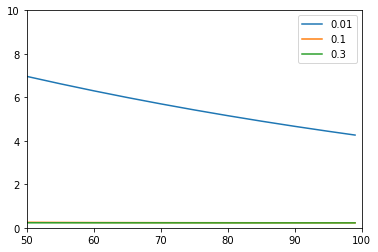

In [128]:
plt.plot(scores['eta=0.01'].num_iter, scores['eta=0.01'].valid_auc,
        label='0.01')
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].valid_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].valid_auc,
        label='0.3')
plt.legend()

plt.ylim([0, 10])
plt.xlim([50, 100])

(50.0, 100.0)

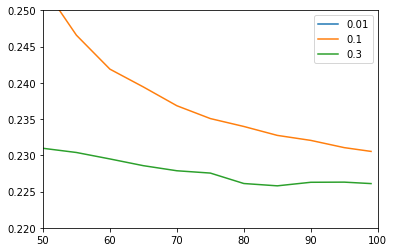

In [129]:
plt.plot(scores['eta=0.01'].num_iter, scores['eta=0.01'].valid_auc,
        label='0.01')
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].valid_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].valid_auc,
        label='0.3')
plt.legend()

plt.ylim([0.22, 0.25])
plt.xlim([50, 100])

In [ ]:
# Which eta leads to the best RMSE score on the validation dataset?

# --> 0.3 <--
# 0.1
# Both gives same